<a href="https://colab.research.google.com/github/kunal-garg-ds/Skin-Cancer-CNN-Detection/blob/main/kunal_garg_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Members: Himanshu Yadav, Amit Kumar Chaudhary & Shreeragh Chandrabose,

##Melanoma Skin Cancer Detection Problem: Upgrad Group Case Study

## Problem Statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
import pandas as pd
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from google.colab import drive

In [ ]:
!fusermount -u drive

In [ ]:
drive.mount("/content/drive/MyDrive/", force_remount = True)

Mounted at /content/drive/MyDrive/


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/MyDrive/DATASETS/melanoma_skin_cancer_detection_dataset/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/MyDrive/DATASETS/melanoma_skin_cancer_detection_dataset/Test")

In [ ]:
# batch, classes, epochs
batch_size = 32
num_classes = 9
epochs = 20

In [ ]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
img_height = 180
img_width = 180

Using 80% of the images for training and 20% for validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/actinic keratosis/ISIC_0025780.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/ISIC_0024504.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/dermatofibroma/ISIC_0025223.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/melanoma/ISIC_0000139.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/nevus/ISIC_0000023.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/pigmented benign keratosis/ISIC_0024446.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/seborrheic keratosis/ISIC_0010852.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/squamous cell carcinoma/ISIC_0024710.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/vascular lesion/ISIC_0024904.jpg


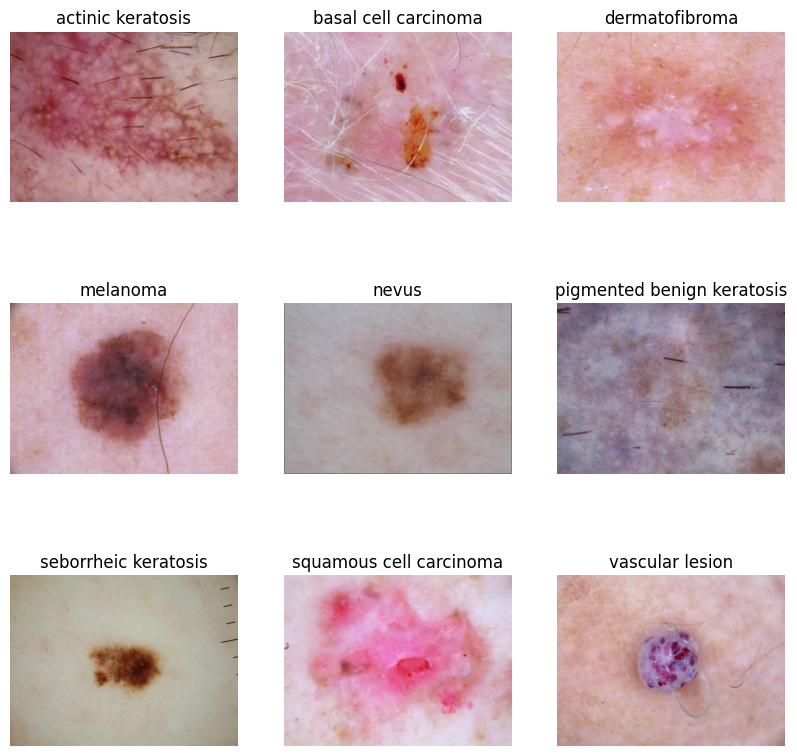

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    files = os.listdir(os.path.join(data_dir_train,class_names[i]))
    image_path = os.path.join(data_dir_train,class_names[i],files[0])
    print(image_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(image_path))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,basal cell carcinoma,376
1,nevus,357
2,melanoma,438
3,dermatofibroma,95
4,seborrheic keratosis,77
5,actinic keratosis,114
6,squamous cell carcinoma,181
7,vascular lesion,139
8,pigmented benign keratosis,462


<Axes: xlabel='No. of Image', ylabel='Class'>

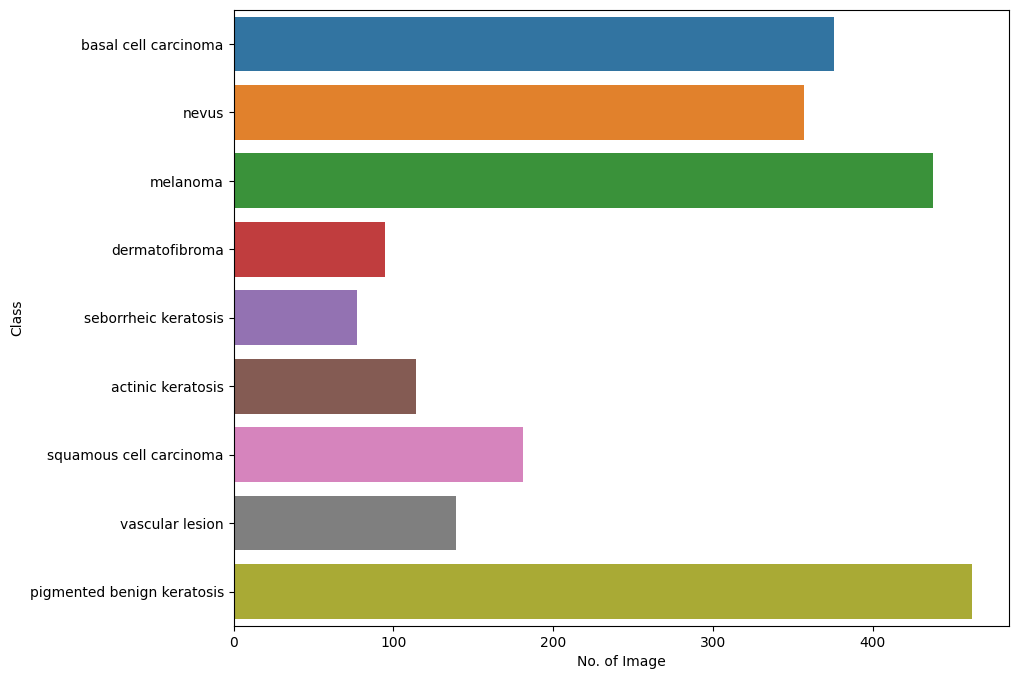

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Findings:

As we see from above table as well as image, actinic keratosis, seborrheic keratosis and dermatofibroma make up the minority classes while dominent classes include melanoma, pigmented benign keratosis, basal cell carcinoma and nevus majorly

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

### Create the baseline model without Augmentor and check for overfit/underfit
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

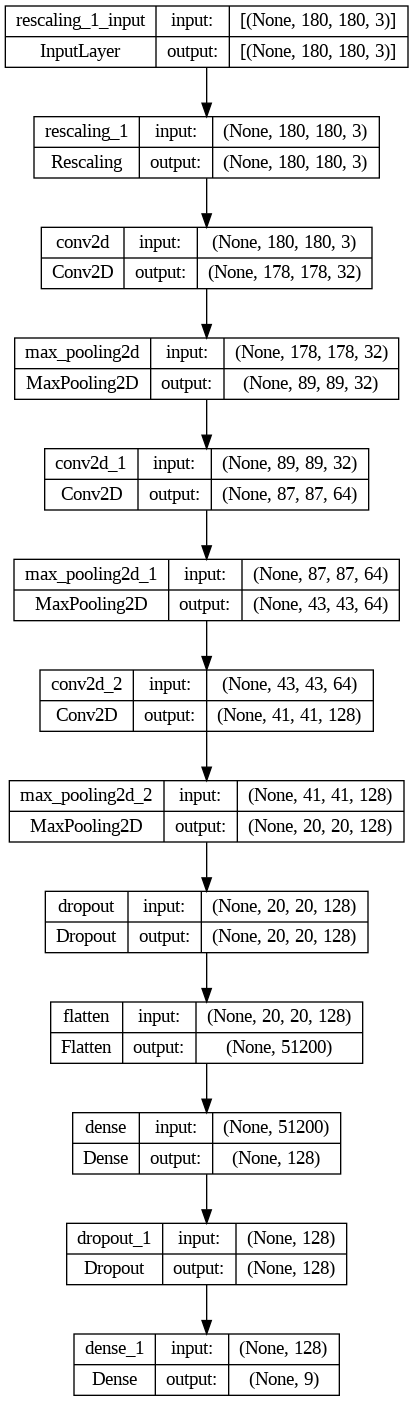

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


### Train the model

In [ ]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 149s 3s/step - loss: 0.3517 - accuracy: 0.2383 - val_loss: 0.3149 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 0.2978 - accuracy: 0.3577 - val_loss: 0.2689 - val_accuracy: 0.4832
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 0.2710 - accuracy: 0.4414 - val_loss: 0.2536 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 0.2550 - accuracy: 0.4911 - val_loss: 0.2565 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 0.2460 - accuracy: 0.5067 - val_loss: 0.2414 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 3s 52ms/step - loss: 0.2379 - accuracy: 0.5301 - val_loss: 0.2515 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 3s 52ms/step - loss: 0.2299 - accuracy: 0.5363 - val_loss: 0.2476 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

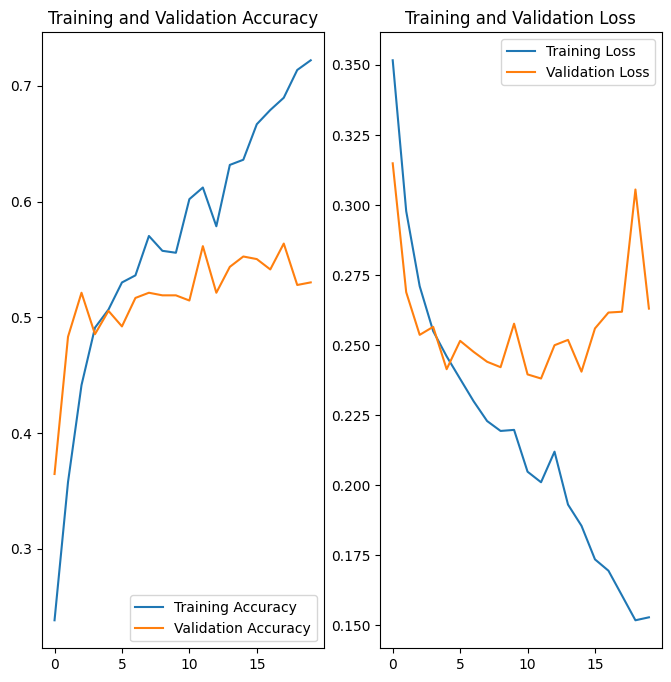

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Checking for Model Overfit or Underfit

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 15ms/step - loss: 0.2630 - accuracy: 0.5302
Accuracy:  0.7940848469734192
Validation Accuracy:  0.5302013158798218
Loss:  0.1177094429731369
Validation Loss 0.2630031704902649


The training accuracy is 79% and validation accuracy is just 53% hence model is overfit. Using Augmentation to reduce class imbalance and retrain the model.

## Checking on Data Augmentation because of overfitting

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.9),
    layers.experimental.preprocessing.RandomZoom(0.9),
  ]
)

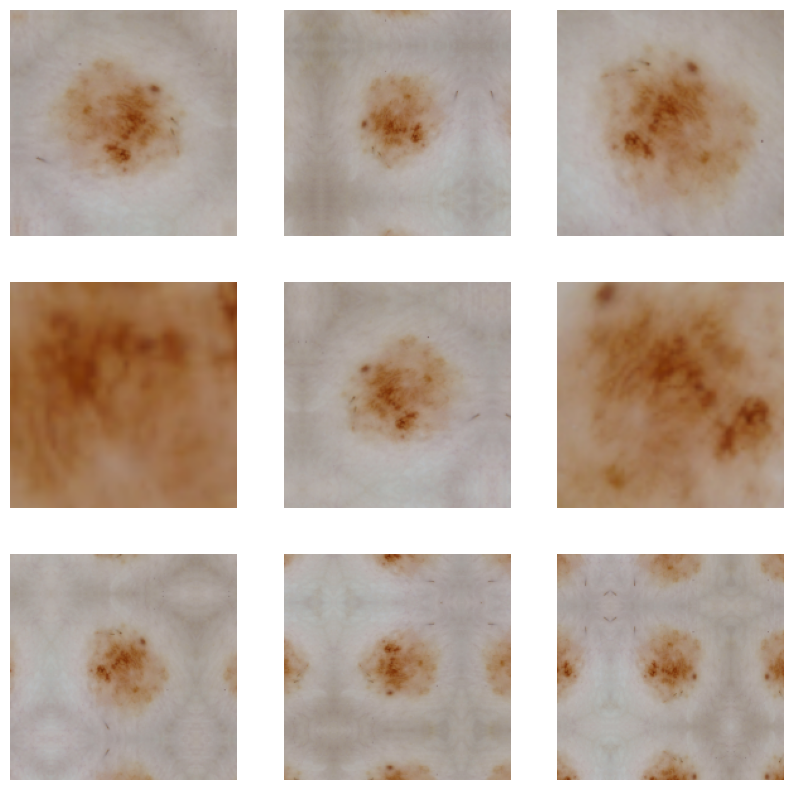

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create, compile and train the model and check its performance

In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)      

In [ ]:
# Compile

optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Train the model

epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 64ms/step - loss: 2.1788 - accuracy: 0.2048 - val_loss: 1.9811 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.9193 - accuracy: 0.2907 - val_loss: 1.7769 - val_accuracy: 0.3423
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7626 - accuracy: 0.3477 - val_loss: 1.5313 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5372 - accuracy: 0.4621 - val_loss: 1.4610 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5065 - accuracy: 0.4626 - val_loss: 1.3980 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3700 - accuracy: 0.5229 - val_loss: 1.4128 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3932 - accuracy: 0.5106 - val_loss: 1.4204 - val_accuracy: 0.5101
Epoch 8/20
56

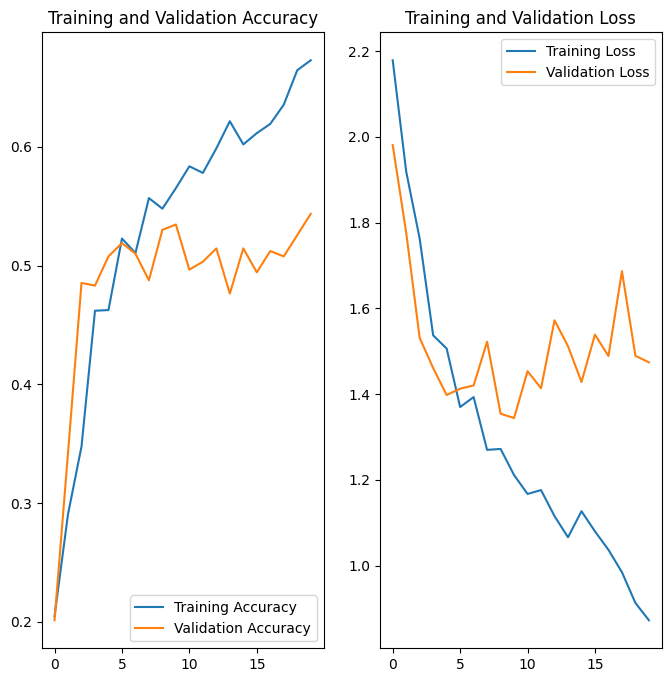

In [ ]:
#Visualize the training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 13ms/step - loss: 1.4743 - accuracy: 0.5436
Accuracy:  0.7606026530265808
Validation Accuracy:  0.5436241626739502
Loss:  0.68309485912323
Validation Loss 1.4742515087127686


### Findings

In the plots and evaluations above, the overfitting has drastically reduced hence we are on the right path

### Retraining the whole model after using Augmentor after checking for distribution

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,basal cell carcinoma
1,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,basal cell carcinoma
2,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,basal cell carcinoma
3,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,basal cell carcinoma
4,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,basal cell carcinoma
...,...,...
2234,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,pigmented benign keratosis
2235,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,pigmented benign keratosis
2236,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,pigmented benign keratosis
2237,/content/drive/MyDrive/MyDrive/Melonema_Case_S...,pigmented benign keratosis


Class=1, n=376 (16.793%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=2, n=95 (4.243%)
Class=6, n=77 (3.439%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=5, n=462 (20.634%)


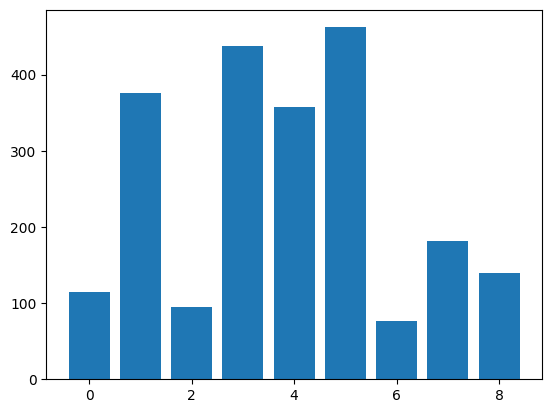

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### Installing Augmentor and trying to handle Class imbalance by adding 500 new images in each class

In [ ]:
!pip install Augmentor
path_to_training_dataset="/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1FFCDAAAA0>: 100%|██████████| 500/500 [00:23<00:00, 21.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B2081535DE0>: 100%|██████████| 500/500 [00:18<00:00, 26.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B1FD42B72E0>: 100%|██████████| 500/500 [00:17<00:00, 28.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1936x1936 at 0x7B1FF98BE350>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1FD42B52A0>: 100%|██████████| 500/500 [01:16<00:00,  6.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1FF1070FA0>: 100%|██████████| 500/500 [00:19<00:00, 25.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B209F03C310>: 100%|██████████| 500/500 [00:37<00:00, 13.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1FF98B80A0>: 100%|██████████| 500/500 [00:17<00:00, 27.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B1FCC55EC80>: 100%|██████████| 500/500 [00:18<00:00, 26.79 Samples/s]


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/actinic keratosis/ISIC_0025780.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/ISIC_0024504.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/dermatofibroma/ISIC_0025223.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/melanoma/ISIC_0000139.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/nevus/ISIC_0000023.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/pigmented benign keratosis/ISIC_0024446.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/seborrheic keratosis/ISIC_0010852.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/squamous cell carcinoma/ISIC_0024710.jpg
/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/vascular lesion/ISIC_0024904.jpg


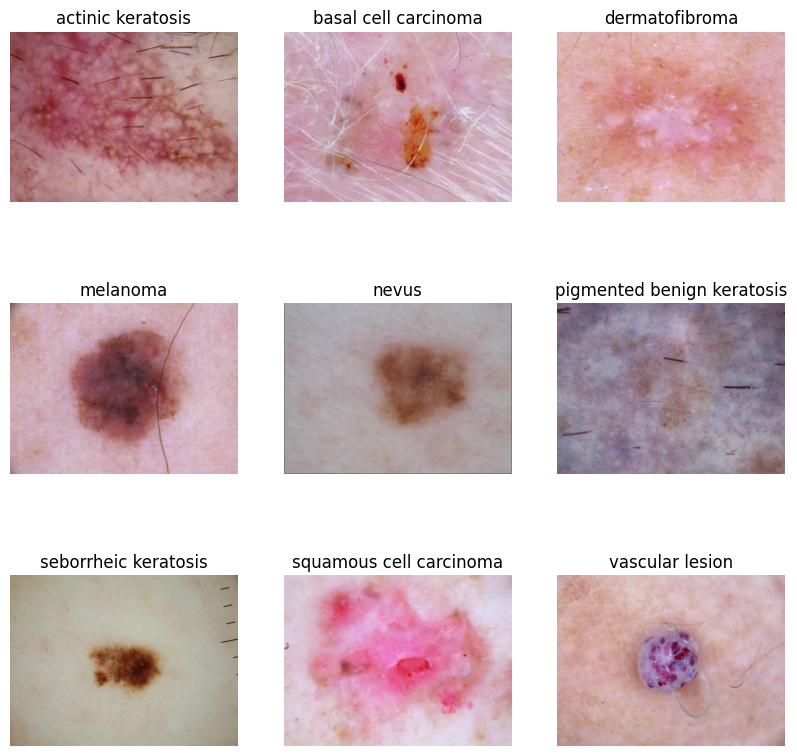

In [ ]:
# Visualizing train data after augmentation

plt.figure(figsize=(10, 10))
for i in range(9):
    files = os.listdir(os.path.join(data_dir_train,class_names[i]))
    image_path = os.path.join(data_dir_train,class_names[i],files[0])
    print(image_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(image_path))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029779.jpg_9f15218c-01a0-48b7-b41b-eed96e6eb713.jpg',
 '/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027544.jpg_4def8b79-f77d-4d03-8ff7-7cf3a5c668ae.jpg',
 '/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026118.jpg_e0a228aa-df8e-4769-9b11-4a412e60cde4.jpg',
 '/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029391.jpg_065cd9b8-95dc-4a68-9ab5-def306e9866b.jpg',
 '/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026117.jpg_e023a0fe-e052-4537-89ea-e9236143a0f1.jpg',
 '/content/drive/MyDrive/MyDrive/Melonema_Case_Study/Datasets/Train/ba

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-86-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 41, 41, 128)     

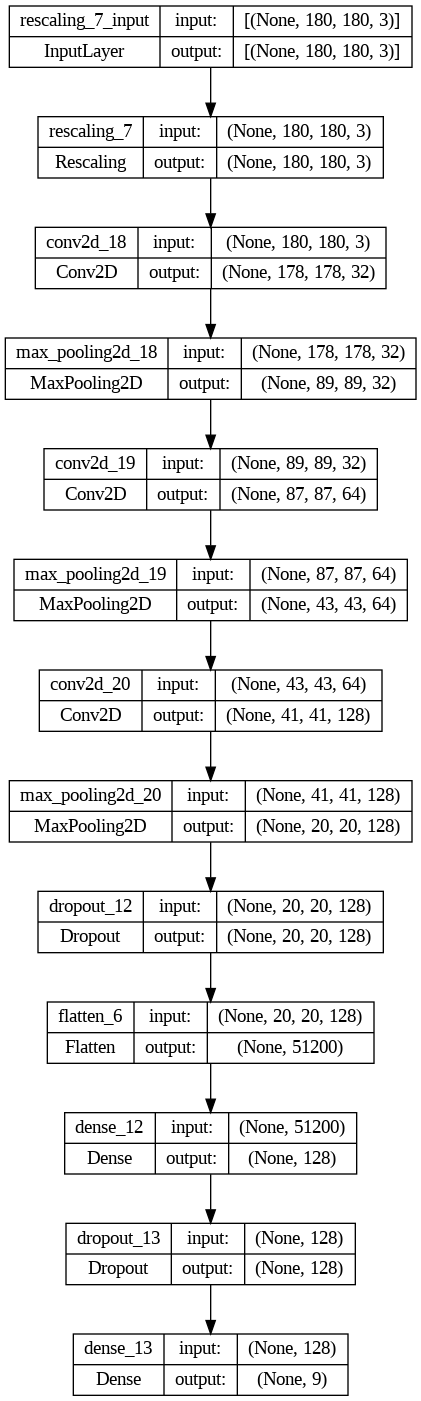

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 41, 41, 128)     

### Train the model

In [ ]:
epochs = 30
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 58s 104ms/step - loss: 0.3089 - accuracy: 0.3092 - val_loss: 0.2843 - val_accuracy: 0.3727
Epoch 2/30
169/169 [==============================] - 9s 54ms/step - loss: 0.2564 - accuracy: 0.4466 - val_loss: 0.2319 - val_accuracy: 0.5011
Epoch 3/30
169/169 [==============================] - 9s 53ms/step - loss: 0.2345 - accuracy: 0.5035 - val_loss: 0.2203 - val_accuracy: 0.5531
Epoch 4/30
169/169 [==============================] - 10s 56ms/step - loss: 0.2163 - accuracy: 0.5601 - val_loss: 0.1991 - val_accuracy: 0.5724
Epoch 5/30
169/169 [==============================] - 9s 53ms/step - loss: 0.1966 - accuracy: 0.6142 - val_loss: 0.1903 - val_accuracy: 0.6013
Epoch 6/30
169/169 [==============================] - 9s 53ms/step - loss: 0.1765 - accuracy: 0.6589 - val_loss: 0.2309 - val_accuracy: 0.5293
Epoch 7/30
169/169 [==============================] - 9s 54ms/step - loss: 0.1621 - accuracy: 0.6918 - val_loss: 0.1703 - val_accuracy: 0.6

### Visualizing training results

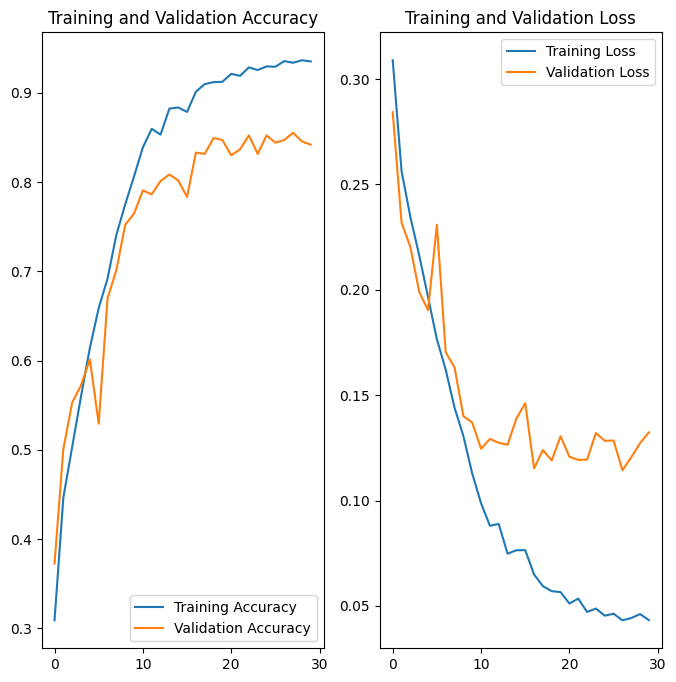

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfit or Underfit?

In [ ]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model did not Overfit and we chose right data augumentation strategy

43/43 [==============================] - 1s 12ms/step - loss: 0.1323 - accuracy: 0.8419
Accuracy:  0.9595697522163391
Validation Accuracy:  0.8418708443641663
Loss:  0.024029133841395378
Validation Loss 0.13233889639377594


### Findings

From the metrics and plots, we can clearly see while the overfitting has reduced quite a lot, the accuracy of the model has also increased manifold

### Prediction

1/1 [==============================] - 0s 255ms/step
Actual Class squamous cell carcinoma
Predicted Class squamous cell carcinoma


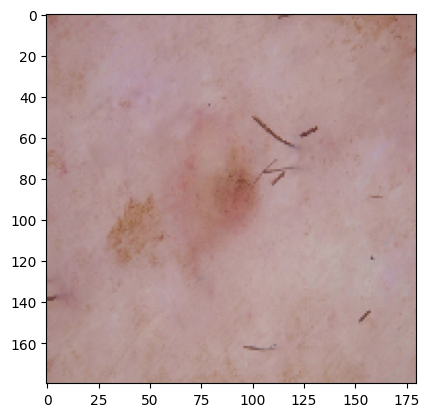

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[7], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[7] +'\n'+ "Predicted Class "+pred_class )